Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearn_pca
from sklearn import decomposition
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# Read and import data
airlines = pd.read_csv('Airlines 2008.csv')
airlines.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [3]:
#Change the ArrDelay variable into a categorical variable
airlines.loc[airlines['ArrDelay'] <= 30, 'ArrDelay'] = 0
airlines.loc[airlines['ArrDelay'] > 30, 'ArrDelay'] = 1

In [4]:
#Check length of the dataset
len(airlines)

7009728

In [5]:
#Type of info per column of the dataset
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [6]:
#Substitute infinity and Nan values by Zeros and check that no Nans are left
airlines = airlines.replace([np.inf, -np.inf], np.nan)
airlines = airlines.fillna(0)   
print(airlines.isnull().sum())
print(airlines.info())

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime    

In [7]:
#Drop "object" type features as they are not going to add information to the model
airlines = airlines.drop(airlines[['UniqueCarrier', 'TailNum','Origin','Dest','CancellationCode']],axis=1)

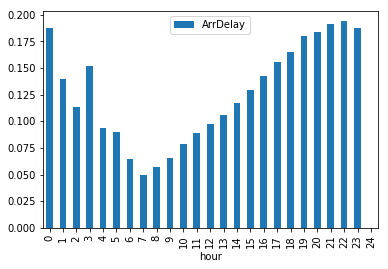

In [8]:
# Compute average number of delayed flights per hour
airlines['hour'] = airlines['CRSArrTime'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
grouped = airlines[['ArrDelay', 'hour' ]].groupby('hour').mean()

# plot average delays by hour
grouped.plot(kind='bar')

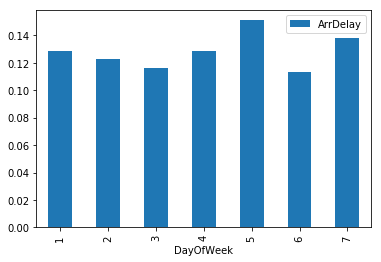

In [9]:
# Compute average number of delayed flights per day of the month
grouped = airlines[['ArrDelay', 'DayOfWeek']].groupby('DayOfWeek').mean()

# plot average delays by day of the month
grouped.plot(kind='bar')

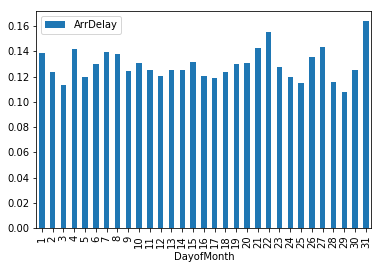

In [10]:
# Compute average number of delayed flights per day
grouped = airlines[['ArrDelay', 'DayofMonth']].groupby('DayofMonth').mean()

# plot average delays by day
grouped.plot(kind='bar')

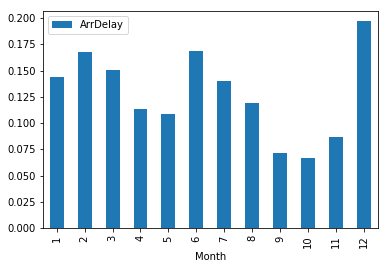

In [11]:
# Compute average number of delayed flights per month
grouped = airlines[['ArrDelay', 'Month']].groupby('Month').mean()

# plot average delays by month
grouped.plot(kind='bar')

In [12]:

XA= airlines.drop('ArrDelay',axis=1)
yA = airlines['ArrDelay']


#Preprocess and scale data
names = XA.columns
XA_scaled = pd.DataFrame(preprocessing.scale(XA), columns = names)
summary = XA_scaled.describe()
XA_scaled.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,hour
0,0.0,-1.577794,-1.446848,0.038133,1.368427,1.354686,1.399788,1.512824,-0.963035,0.048515,...,-0.544551,-0.710139,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,1.520908
1,0.0,-1.577794,-1.446848,0.038133,-1.090467,-1.273203,-0.821755,-1.025128,0.513224,0.048515,...,-0.343789,-0.535472,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-0.965033
2,0.0,-1.577794,-1.446848,0.038133,-1.338521,-1.520914,-1.185581,-1.543077,-0.905432,-0.396643,...,-0.745313,0.075863,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-1.586519
3,0.0,-1.577794,-1.446848,0.038133,-0.751852,-0.853172,-0.726205,-0.817948,-0.243766,-0.507932,...,-0.745313,-0.797473,-0.141415,-0.04969,-0.173255,-0.071994,-0.226623,-0.019013,-0.223486,-0.757872
4,0.0,-1.577794,-1.446848,0.038133,1.025875,0.923885,0.936737,0.891285,0.864447,-0.480110,...,-0.745313,-0.535472,-0.141415,-0.04969,-0.072252,-0.071994,-0.226623,-0.019013,1.359403,0.899423


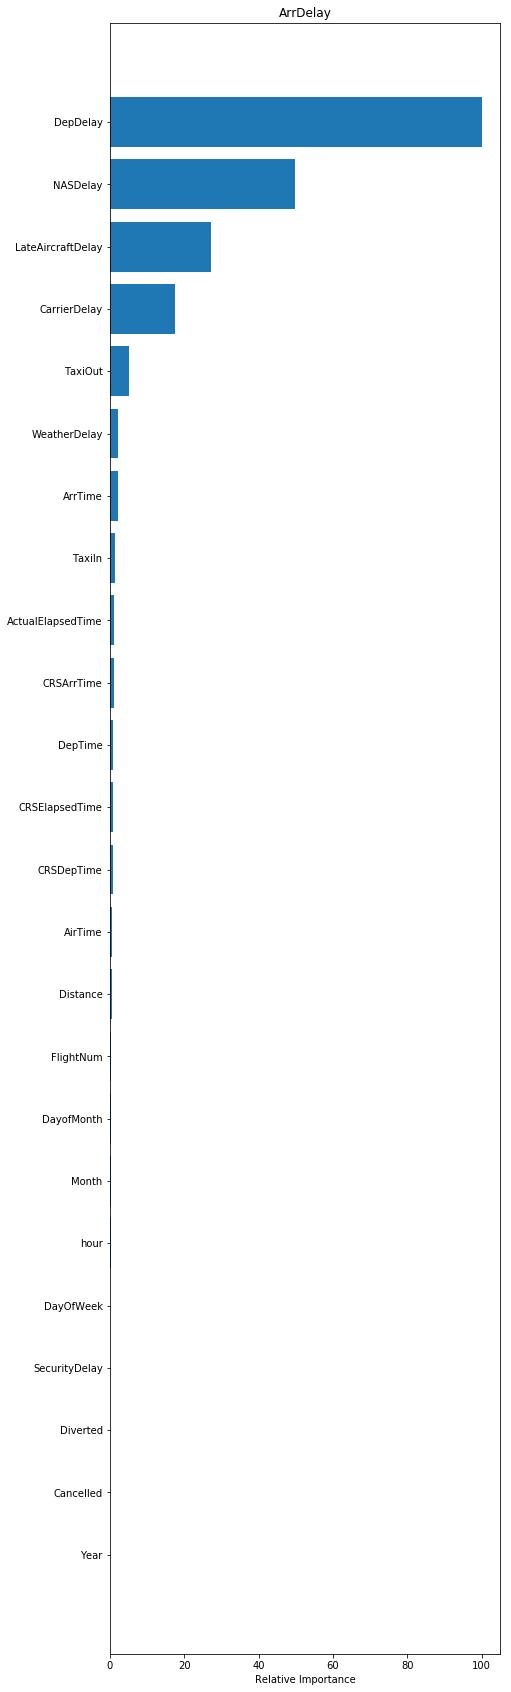

In [13]:
#Calculate Feature Importance using Random Forest
rf = RandomForestClassifier()
rf.fit(XA, yA)

#Define feature importance
feature_importance8 = rf.feature_importances_

# Make importances relative to max importance.
feature_importance8 = 100.0 * (feature_importance8 / feature_importance8.max())
sorted_idx = np.argsort(feature_importance8)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7, 30))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance8[sorted_idx], align='center')
plt.yticks(pos, XA.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('ArrDelay')
plt.show()

In [14]:
#From Feature selection, we´ll only keep the most meaningful features >q0%
['DepDelay','NASDelay','LateAircraftDelay','CarrierDelay','TaxiOut','WeatherDelay']

#Set up the new dataset based on the meaningful features
airlines2=airlines[['ArrDelay','DepDelay','NASDelay','LateAircraftDelay','CarrierDelay','TaxiOut','WeatherDelay']]


In [15]:
#Check the new dataset
airlines2.head()

,ArrDelay,DepDelay,NASDelay,LateAircraftDelay,CarrierDelay,TaxiOut,WeatherDelay
0,0.0,8.0,0.0,0.0,0.0,8.0,0.0
1,0.0,19.0,0.0,0.0,0.0,10.0,0.0
2,0.0,8.0,0.0,0.0,0.0,17.0,0.0
3,0.0,-4.0,0.0,0.0,0.0,7.0,0.0
4,1.0,34.0,0.0,32.0,2.0,10.0,0.0


In [16]:
#Count number of datapoints for ArrDelay
airlines2['ArrDelay'].value_counts()

0.0    6108330
1.0     901398
Name: ArrDelay, dtype: int64

In [17]:
#Downsample majority class (due to computational restrictions we downsample the majority instead of upsampling the minority)

# Separate majority and minority classes
airlines_majority = airlines2[airlines2.ArrDelay==0]
airlines_minority = airlines2[airlines2.ArrDelay==1]
 
# Downsample mairlinesass
airlines_majority_downsampled = resample(airlines_majority, replace=False, n_samples=901398, random_state=123) 
 
# Combine minority class with downsampled majority class
airlines_downsampled = pd.concat([airlines_majority_downsampled, airlines_minority])
 
# Display new class counts
airlines_downsampled.ArrDelay.value_counts()

1.0    901398
0.0    901398
Name: ArrDelay, dtype: int64

In [18]:
#Preprocess and scale data to fit into the models
airlines_downsampled2=airlines_downsampled.drop('ArrDelay',axis=1)

names = airlines_downsampled2.columns
X2 = pd.DataFrame(preprocessing.scale(airlines_downsampled2), columns = names)
X2.describe()

,DepDelay,NASDelay,LateAircraftDelay,CarrierDelay,TaxiOut,WeatherDelay
count,1.802796e+06,1.802796e+06,1.802796e+06,1.802796e+06,1.802796e+06,1.802796e+06
mean,4.217699e-13,-2.033507e-12,3.680095e-12,3.222554e-12,2.195154e-13,-1.001364e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.787945e+00,-3.872791e-01,-4.269176e-01,-3.112424e-01,-1.143078e+00,-1.357592e-01
25%,-6.441609e-01,-3.872791e-01,-4.269176e-01,-3.112424e-01,-5.097678e-01,-1.357592e-01
50%,-4.086760e-01,-3.872791e-01,-4.269176e-01,-3.112424e-01,-2.794733e-01,-1.357592e-01
75%,3.314193e-01,-1.233784e-01,-1.043743e-01,-3.112424e-01,1.235420e-01,-1.357592e-01
max,4.088528e+01,4.437687e+01,3.494533e+01,6.470832e+01,2.355600e+01,7.532159e+01


In [19]:
#Define Outcome & Predictors

y = airlines_downsampled['ArrDelay']
X2 = airlines_downsampled2

#Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

#KFold for cross validation analysis
kf = KFold(5)

***PCA Analysis***

In [20]:
#PCA Analysis

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X2)

# Create a PCA object
pca = decomposition.PCA(n_components=6)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features

XPCA = pd.DataFrame(X_std_pca)
XPCA.head()


,0,1,2,3,4,5
0,-0.990197,0.293276,0.034096,0.098927,0.152293,-0.017928
1,-0.727210,-0.353565,0.067869,-0.017779,0.324358,-0.168489
2,-0.966627,0.299113,0.034229,0.099270,0.158133,0.004606
3,-0.577752,0.354579,0.038816,0.101248,0.210907,0.373279
4,-1.013628,0.409965,0.026794,0.109626,0.277234,-0.031036


***Logistic Regression***

In [21]:
# Initialize and fit the model.
lr = LogisticRegression()
fittrain = lr.fit(X_train,y_train)
fittest = lr.fit(X_test,y_test)

# Predict on training set
predtrain_y = lr.predict(X_train)
predtest_y = lr.predict(X_test)

In [22]:
from sklearn.metrics import classification_report

#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrain_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00    631255
        1.0       0.99      1.00      1.00    630702

avg / total       1.00      1.00      1.00   1261957

[[626038   5217]
 [   986 629716]]
Training set accuracy:
Percent Type I errors: 0.004134055280805923
Percent Type II errors: 0.0007813261466119686




In [23]:
#Testing Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtest_y)
print(cnf)

table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(lr,X2,y,cv=kf))
print(cross_val_score(lr,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(lr,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99    270143
        1.0       0.99      1.00      0.99    270696

avg / total       0.99      0.99      0.99    540839

[[267735   2408]
 [   464 270232]]
Test set accuracy:
Percent Type I errors: 0.004452341639563715
Percent Type II errors: 0.000857926295995666
[ 0.98889783  0.9883847   0.99486076  0.99830818  0.99856889]
0.993804071512
Cross validation PCA: 0.993794641792


*** Random Forest***

In [24]:
# Train model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.fit(X_test, y_test)

# Predict on training set
predtrainrf_y = rf.predict(X_train)
predtestrf_y = rf.predict(X_test)

In [25]:
#Training Scores
target_names = ['0', '1']
print(classification_report(y_train, predtrainrf_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainrf_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainrf_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    631255
          1       1.00      1.00      1.00    630702

avg / total       1.00      1.00      1.00   1261957

[[630115   1140]
 [   935 629767]]
Training set accuracy:
Percent Type I errors: 0.0009033588307684018
Percent Type II errors: 0.0007409127252354874




In [26]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(rf,X2,y,cv=kf))
print(cross_val_score(rf,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(rf,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    270143
          1       1.00      1.00      1.00    270696

avg / total       1.00      1.00      1.00    540839

[[270112     31]
 [    97 270599]]
Test set accuracy:
Percent Type I errors: 5.731835167212424e-05
Percent Type II errors: 0.00017935097136116294
[ 0.99833037  0.99817783  0.99859385  0.99837752  0.99849955]
0.998416903623
Cross validation PCA: 0.998049141599


***Naive - Bayes***

In [27]:
# Train model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.fit(X_test, y_test)

# Predict on training set
predtrainbnb_y = bnb.predict(X_train)
predtestbnb_y = bnb.predict(X_test)

In [28]:
#Training Scores
target_names = ['0', '1']
print(classification_report(y_train, predtrainbnb_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainbnb_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainbnb_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

          0       0.94      0.92      0.93    631255
          1       0.93      0.94      0.93    630702

avg / total       0.93      0.93      0.93   1261957

[[583114  48141]
 [ 36680 594022]]
Training set accuracy:
Percent Type I errors: 0.03814789251931722
Percent Type II errors: 0.029065966589986822




In [29]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestbnb_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestbnb_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestbnb_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(bnb,X2,y,cv=kf))
print(cross_val_score(bnb,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(bnb,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

          0       0.94      0.92      0.93    270143
          1       0.92      0.94      0.93    270696

avg / total       0.93      0.93      0.93    540839

[[249193  20950]
 [ 15894 254802]]
Test set accuracy:
Percent Type I errors: 0.0387361118558388
Percent Type II errors: 0.029387673596023955
[ 0.92341358  0.92359364  0.9331011   0.94183754  0.94061998]
0.932513167934
Cross validation PCA: 0.910310976001


***Gradient Boosting Classifier***

In [30]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
clf.fit(X_test, y_test)

# Predict on training set
predtrainclf_y = clf.predict(X_train)
predtestclf_y = clf.predict(X_test)

In [31]:
#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrainclf_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainclf_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainclf_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00    631255
        1.0       0.99      1.00      1.00    630702

avg / total       1.00      1.00      1.00   1261957

[[627961   3294]
 [  1247 629455]]
Training set accuracy:
Percent Type I errors: 0.002610231568904487
Percent Type II errors: 0.0009881477736563133




In [46]:
#Test Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtestclf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestclf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestclf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(clf,X2,y,cv=kf))
print(cross_val_score(clf,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(clf,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00    270143
        1.0       0.99      1.00      1.00    270696

avg / total       1.00      1.00      1.00    540839

[[268729   1414]
 [   563 270133]]
Test set accuracy:
Percent Type I errors: 0.002614456427883344
Percent Type II errors: 0.001040975225529224
[ 0.99247282  0.99217604  0.99637507  0.99744563  0.99754548]
0.995203008399
Cross validation PCA: 0.995539707916


***LDA Classifier***

In [42]:
# LDA Classification

lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)
lda.fit(X_test, y_test)

# Predict on training set
predtrainlda_y = lda.predict(X_train)
predtestlda_y = lda.predict(X_test)

In [43]:
#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrainlda_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainlda_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainlda_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89    631255
        1.0       0.99      0.76      0.86    630702

avg / total       0.90      0.88      0.88   1261957

[[628611   2644]
 [148542 482160]]
Training set accuracy:
Percent Type I errors: 0.0020951585513611
Percent Type II errors: 0.11770765564912275




In [44]:
#Test Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtestlda_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestlda_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestlda_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))
print(cross_val_score(lda,X2,y,cv=kf))
print(cross_val_score(lda,X2,y,cv=kf).mean())
print('Cross validation PCA:', cross_val_score(lda,XPCA,y,cv=kf).mean())

             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89    270143
        1.0       0.99      0.76      0.86    270696

avg / total       0.90      0.88      0.88    540839

[[268983   1160]
 [ 63941 206755]]
Test set accuracy:
Percent Type I errors: 0.002144815739989165
Percent Type II errors: 0.11822557175055792
[ 0.96879299  0.96926439  0.88088773  0.61805419  0.6482462 ]
0.81704909943
Cross validation PCA: 0.81704909943


Before running the model, the data was cleaned. The NaN and values values were replaced by zeros. To run the model and predict the arrival delay, the first thing that was done was to select the most meaningful features. After cleaning the data, the features that were over 10% meaningfulness using RandomForest were selected:

'DepDelay 
'NASDelay'
'LateAircraftDelay'
'CarrierDelay'
'TaxiOut'
'WeatherDelay'

As the delays and on-time arrivals were unevenly spread in the dataset, the dataset was resampled. In this case and due to the computing power requirements, the majority (on-time arrivals) was downsampled. The resampled dataset was split into a train and a test dataset at 30% test dataset ratio.

The new dataset was run through different models: Naive Bayes, LDA, RandomForest, Logistic Regression and Gradient Boosting Classifier. Every model was run on a PCA predictors to see the max accuracy that the model was able to obtain through cross validation. 

The model scoring a better result in the test sample was Random Forest scorring 99% and having a reduced % of type I and type II errors in the model. The model scoring the worst reult was LDA.

I couldn't run SVC due to computational restrictions in my computer. From the models that were run the best score was achieved by the Random Forest model